In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import interpolate

In [2]:
# load bp
with open("bp.csv", 'r') as bp_file:
    data = pd.read_csv(bp_file, sep=';')

print("BP file columns:\n\n%s" % data.columns)

# get first and second col and change representation to numpy-like
rs0dist = data[data.columns[0]].as_matrix()
rs0dose = data[data.columns[1]].as_matrix()

rs0dist = np.nan_to_num(rs0dist)
rs0dose = np.nan_to_num(rs0dose)

peak_max_position = rs0dist[rs0dose.argmax()]
print("\nDose == 1 is at range %s for %s" % (peak_max_position, data.columns[1]))

BP file columns:

Index(['x0', 'rs0', 'x0.955', 'y0.955', 'x1000', 'rs1000', 'x2000', 'y2000',
       'x3000', 'rs3000', 'x', 'rs4000', 'x.1', 'rs5000', 'x.2', 'rs6000',
       'x.3', 'rs7000', 'x.4', 'rs8000', 'x.5', 'rs9000', 'x.6', 'rs10000',
       'x.7', 'rs11000', 'x.8', 'rs12000', 'x.9', 'rs13000', 'x.10', 'rs14000',
       'x.11', 'rs15000', 'x.12', 'rs16000', 'x.13', 'rs17000', 'x.14',
       'rs18000'],
      dtype='object')

Dose == 1 is at range 28.24 for rs0


In [3]:
# load file with positions and weights
with open("pos.txt", "r") as pos_file:
    pos_we_data = pd.read_csv(pos_file, sep=';')

positions = pos_we_data['position'].as_matrix()
weights = pos_we_data['weight'].as_matrix()

print("Positions: %s" % positions)
print("Weights: %s " % weights)

Positions: [ 12.  14.  18.  20.  24.  26.]
Weights: [ 0.1    0.05   0.125  0.225  0.15   0.35 ] 


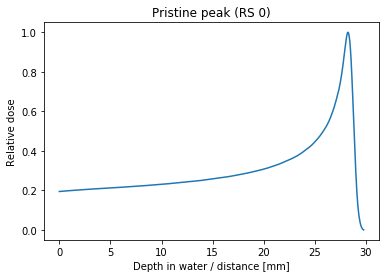

In [4]:
plt.plot(rs0dist, rs0dose)
plt.title("Pristine peak (RS 0)")
plt.xlabel("Depth in water / distance [mm]")
plt.ylabel("Relative dose")

In [5]:
def fit_fun3(x, a, b, c):
    return a*x**2 + b*x + c

def fit_fun4(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

def fit_fun5(x, a, b, c, d, e):
    return a*x**4 + b*x**3 + c*x**2 + d*x + e

coeffs3, _ = curve_fit(fit_fun3, rs0dist, rs0dose)
coeffs4, _ = curve_fit(fit_fun4, rs0dist, rs0dose)
coeffs5, _ = curve_fit(fit_fun5, rs0dist, rs0dose)

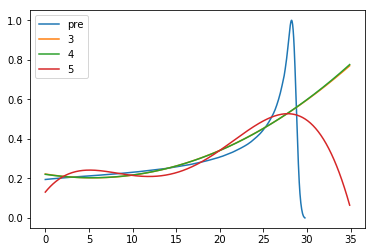

In [6]:
new_domain = np.arange(0, 35, 0.1)

fitted3 = fit_fun3(new_domain, coeffs3[0], coeffs3[1], coeffs3[2])
fitted4 = fit_fun4(new_domain, coeffs4[0], coeffs4[1], coeffs4[2], coeffs4[3])
fitted5 = fit_fun5(new_domain, coeffs5[0], coeffs5[1], coeffs5[2], coeffs5[3], coeffs5[4])

pre, = plt.plot(rs0dist, rs0dose, label="pre")
plot3, = plt.plot(new_domain, fitted3, label="3")
plot4, = plt.plot(new_domain, fitted4, label="4")
plot5, =plt.plot(new_domain, fitted5, label="5")
plt.legend(handles=[pre, plot3, plot4, plot5], loc=2)

---

**This doesn't look very good, so let's try point by point analyze and returning nearest:**

---

In [7]:
def find_nearest(array, value):
    # should be a speed boost, because our data is sorted
    # np.searchsorted(array, value, side="left")
    # should be > > if something was found
    return (np.abs(array-value)).argmin()

def peak_function(x_base, y_base):
    def kle(x):
        return np.array([y_base[find_nearest(x_base, point)] for point in x])
    return kle

In [8]:
rs0aprx = peak_function(rs0dist, rs0dose)

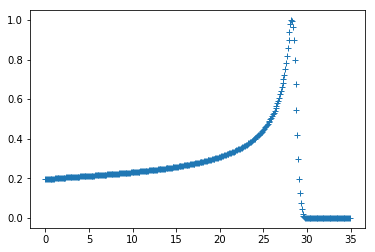

In [9]:
dd = np.arange(0, 35, .1)
plt.plot(dd, rs0aprx(dd), '+')

In [10]:
print(data.columns[25])

rs11000


In [11]:
# rs11000dist = data[data.columns[24]].as_matrix()
rs11000dose = data[data.columns[25]].as_matrix()

rs11000dist = rs0dist
rs11000dose = np.nan_to_num(rs11000dose)

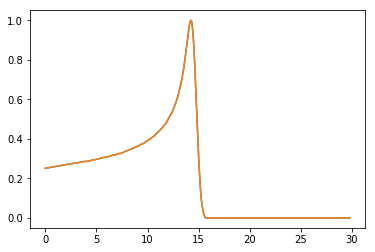

In [12]:
plt.plot(rs11000dist, rs11000dose)
plt.plot(rs0dist, rs11000dose)

The strange line on X axis is the result of using `np.nan_to_num()`, dist/dose vals were np.nan after reading from file and they became zeros...

In [13]:
r11000aprx = peak_function(rs0dist, rs11000dose)

(14, 16)

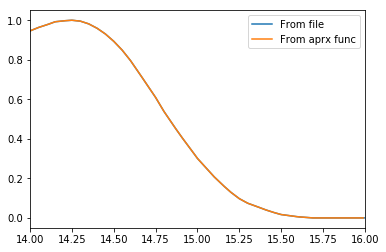

In [14]:
dd = np.arange(14, 16, .01)
before, = plt.plot(rs11000dist, rs11000dose, '-', label="From file")
after, = plt.plot(dd, r11000aprx(dd), '-', label="From aprx func")
plt.legend(handles=[before, after])
plt.xlim(14,16)

In [15]:
tck = interpolate.splrep(rs0dist, rs0dose)
xnew = np.arange(0, 30, .005)
ynew = interpolate.splev(xnew, tck, der=0)

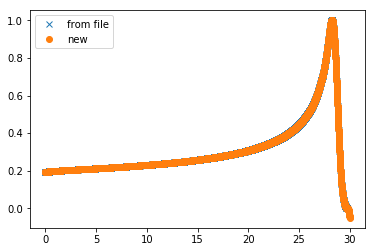

In [16]:
plt.plot(rs0dist, rs0dose, 'x', label="from file")
plt.plot(xnew, ynew, 'o', label="new")
plt.legend()

In [17]:
rs11000tck = interpolate.splrep(rs11000dist, rs11000dose)
x11new = np.arange(0, 30, .005)
y11new = interpolate.splev(x11new, rs11000tck, der=0)

rs11000tck

(array([  0.  ,   0.  ,   0.  , ...,  29.77,  29.77,  29.77]),
 array([ 0.25084   ,  0.25091163,  0.25100175, ...,  0.        ,
         0.        ,  0.        ]),
 3)

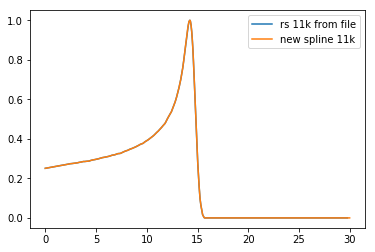

In [18]:
plt.plot(rs11000dist, rs11000dose, '-', label="rs 11k from file")
plt.plot(x11new, y11new, '-', label="new spline 11k")
plt.legend()

## Testing peaks with position and weight

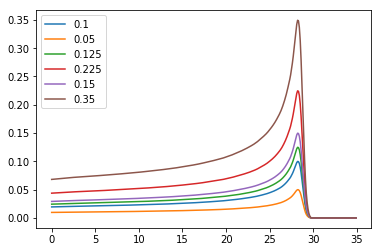

In [19]:
dom = np.arange(0, 35, 0.1)
rs0aprx = peak_function(rs0dist, rs0dose)

we_plots = []
for w in np.array(weights):
    we_plots.append(plt.plot(dom, w*rs0aprx(dom), label=str(w))[0])
plt.legend(handles=we_plots)

Let's test moving peaks on rs0

In [20]:
peak_max_position = rs0dist[rs0dose.argmax()]

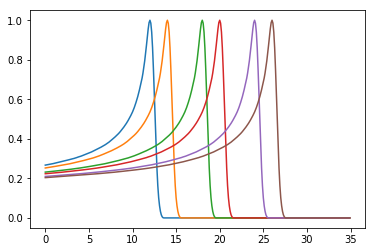

In [21]:
for pos in positions:
    plt.plot(dom, rs0aprx(dom + (peak_max_position-pos)))

Now try rs11000

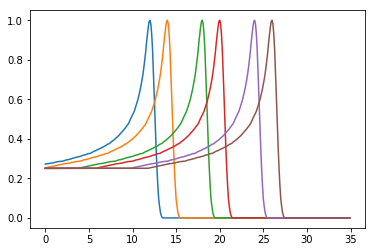

In [22]:
peak11k_max_position = rs11000dist[rs11000dose.argmax()]
dom11 = np.arange(0, 35, 0.1)
rs11000aprx = peak_function(rs11000dist, rs11000dose)

for pos in positions:
    plt.plot(dom11, rs11000aprx(dom11 + (peak11k_max_position-pos)))

### Try weights and positions on rs0 and plot sum of it

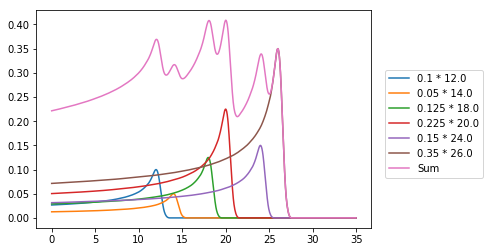

In [23]:
test_domain = np.arange(0, 35, 0.01)

processed_peaks = []
for e in range(len(positions)):
    tmp_peak = weights[e] * rs0aprx(test_domain + (peak_max_position - positions[e]))
    processed_peaks.append(tmp_peak)
    plt.plot(test_domain, tmp_peak, label=str("%s * %s" % (weights[e], positions[e])))

plt.plot(test_domain, sum(processed_peaks), label="Sum")
plt.legend(bbox_to_anchor=(1.35, 0.75))

In [24]:
# sum of all peaks
print("Domain:\n%s\nValues:\n%s" % (test_domain, sum(processed_peaks)))

Domain:
[  0.00000000e+00   1.00000000e-02   2.00000000e-02 ...,   3.49700000e+01
   3.49800000e+01   3.49900000e+01]
Values:
[  2.21482750e-01   2.21522500e-01   2.21565500e-01 ...,   1.10000000e-04
   1.10000000e-04   1.10000000e-04]


In [25]:
sum_frame = pd.DataFrame(data={"x": test_domain, "val": sum(processed_peaks)})

In [26]:
# save to file
sum_frame.to_csv("result.csv", sep=';')